# Stock price forecasting

The dataset contains stock market data of Amazon.com, Inc(AMZN) and it can be downloaded from Yahoo Finance.

The data shows the stock price of Amazon.com, Inc(AMZN) from 2011-01-01 till 2017–11–10. The goal is to train an ARIMA model with optimal parameters that will forecast the closing price of the stocks on the test data.

### Import Libraries

In [47]:
import os
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

**Load the Amazon closing prices data**

In [2]:
stock_ticker = 'AMZN'
ticker_df = yf.download(stock_ticker, start="2011-01-01", end="2021-05-31")
ticker_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,181.369995,186.000000,181.210007,184.220001,184.220001,5331400
2011-01-04,186.149994,187.699997,183.779999,185.009995,185.009995,5031800
2011-01-05,184.100006,187.449997,184.070007,187.419998,187.419998,3418800
2011-01-06,186.500000,187.410004,185.250000,185.860001,185.860001,3179700
2011-01-07,187.880005,188.449997,183.740005,185.490005,185.490005,5221700
...,...,...,...,...,...,...
2021-05-24,3215.500000,3257.949951,3210.500000,3244.989990,3244.989990,2422800
2021-05-25,3266.669922,3279.820068,3213.760010,3259.050049,3259.050049,3261100
2021-05-26,3274.590088,3295.729980,3258.510010,3265.159912,3265.159912,2384000


**Plot closing price of the stock from the dataframe**

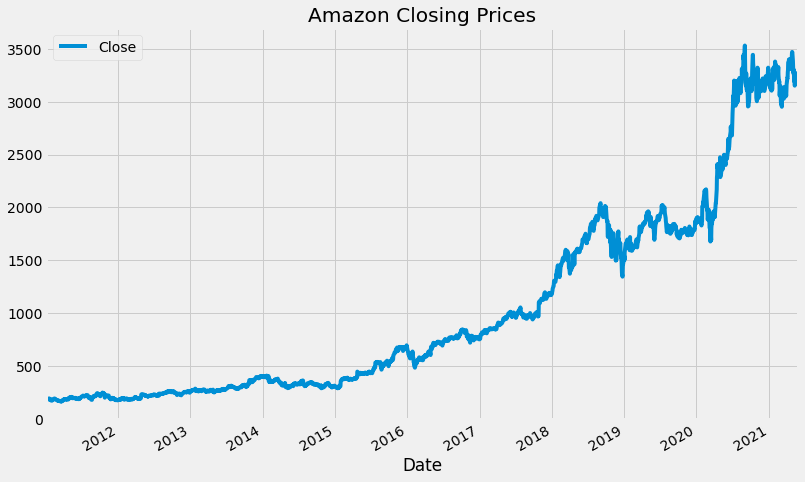

In [3]:
ticker_df['Close'].plot(
    title='Amazon Closing Prices', 
    legend='Close', 
    figsize=(12, 8))
plt.margins(x=0)

From the above graph, we observe an upwards trend. As we know, a time series with an upward or downward trend is non-stationary. So, First, we need to check if a series is stationary or not because time series analysis only works with stationary data. 

We can use one of most popular statistical test called ADF(Augmented Dickey-Fuller)Test. It can be used to test whether a given time series is stationary or not by determing the presence of unit root in the series.
The null and alternate hypothesis of this test is:

- Null Hypothesis: The series has a unit root (value of a =1)

- Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

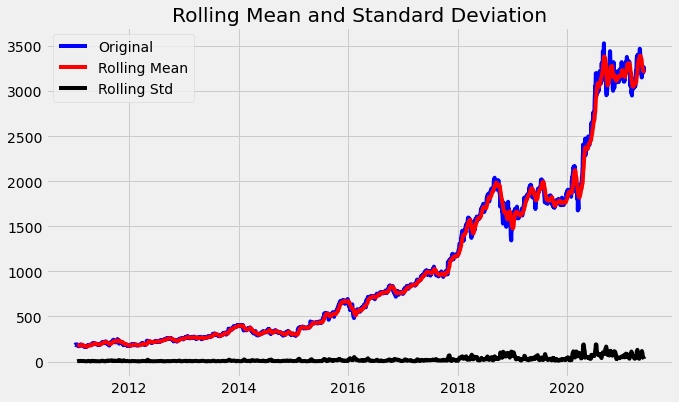

Results of dickey fuller test
Test Statistics                   1.828993
p-value                           0.998405
No. of lags used                 27.000000
Number of observations used    2591.000000
critical value (1%)              -3.432876
critical value (5%)              -2.862656
critical value (10%)             -2.567364
dtype: float64


In [4]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(ticker_df['Close'])

**Observations**

From the above test results, we can observe the following:

- p-value is greater than the significance value 0.05. So, we cannot reject the null hypothesis.
- test statistics is also greater than the critical value.

Therefore, the time series data is non-stationary.

**Decomposition**

A time series consists of three systematic components(a time series that have consistency and can be described and modeled) including level, trend, seasonality, and one non-systematic component(that cannot be directly modeled) called noise. To analyze the time series data, we need to separate the trend, seasonality and noise.

These components are defined as follows:

- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series. 

<Figure size 720x432 with 0 Axes>

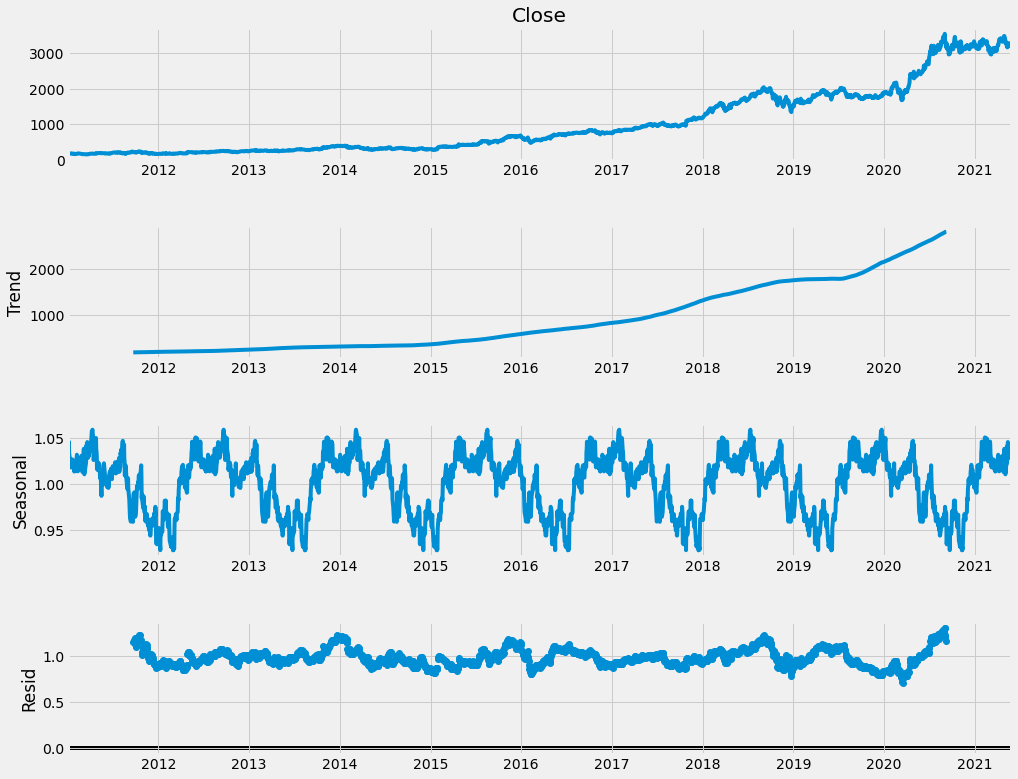

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ticker_df['Close'], model='multiplicative', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

To reduce the magnitude of the values and the rising trend in the series, we use log of the series.

No handles with labels found to put in legend.


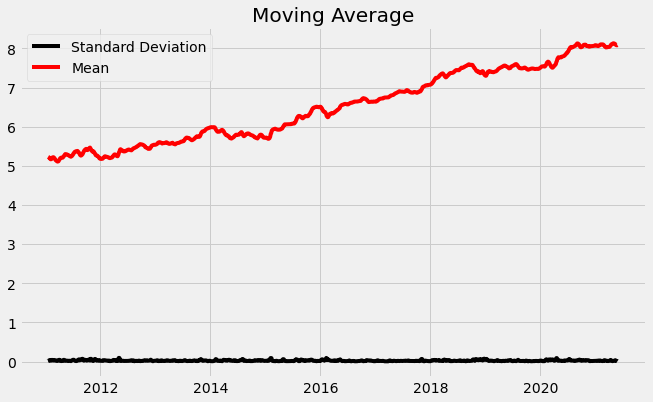

In [6]:
ticker_log_df = np.log(ticker_df['Close'])
moving_avg = ticker_log_df.rolling(12).mean()
std_dev = ticker_log_df.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

<Figure size 720x432 with 0 Axes>

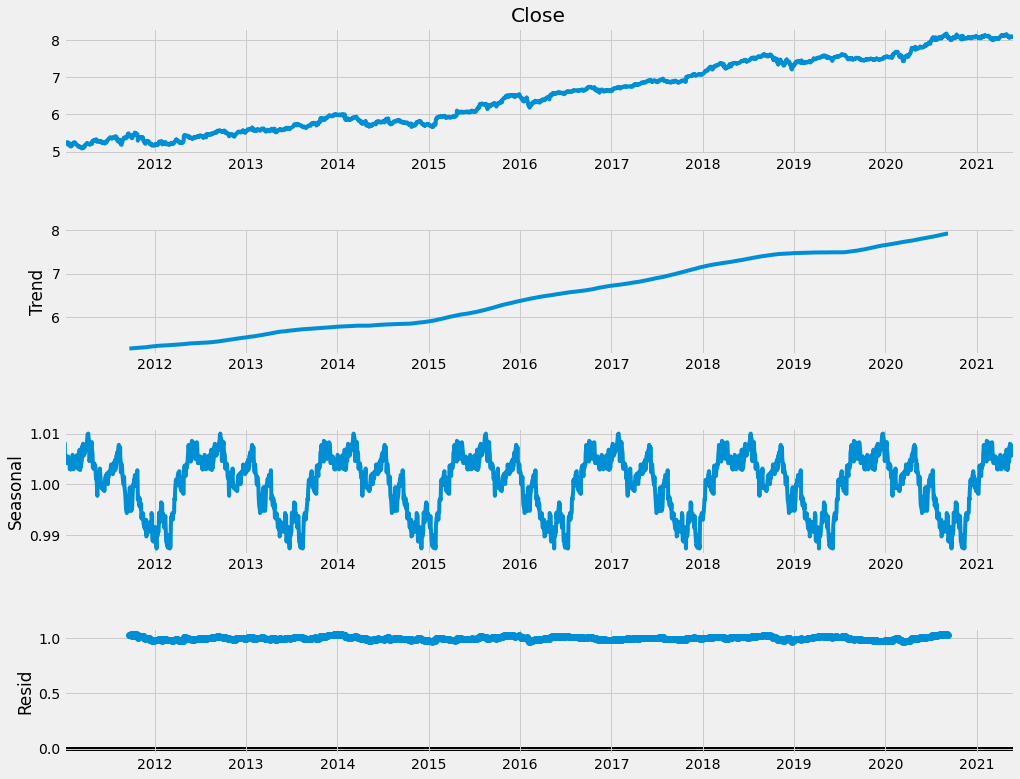

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ticker_log_df, model='multiplicative', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

### Forecasting the Close Price using an ARIMA Model

Using the Close Price, estimate an ARIMA model. First, we need to choose the parameters(p,d,q) of the model. There are so many ways to find the parameters. We use the following:

- ACF and PACF

- Auto ARIMA

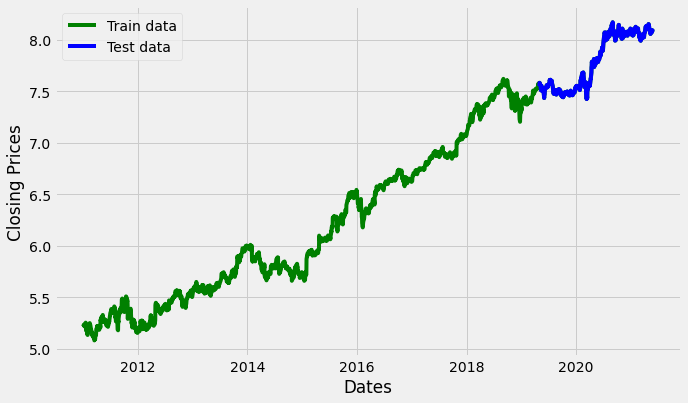

In [48]:
# Split the data set into a 70% for training and 30% for testing
split_data = int(len(ticker_log_df)*0.80)

train_data = ticker_log_df[0:split_data]
test_data = ticker_log_df[split_data:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(ticker_log_df, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [49]:
len(test_data)

524

###  1. Autocorrelation Function and Partial Autocorrelation Function Analysis

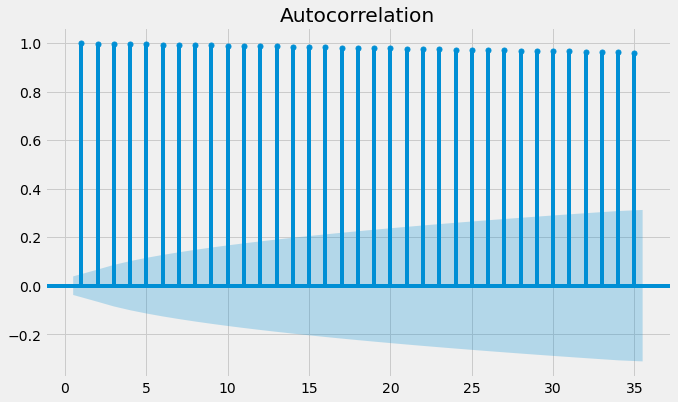

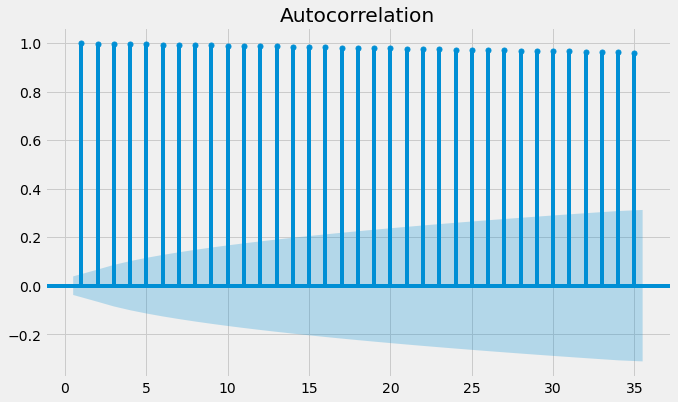

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the autocorrelation of the Settle Prices
plot_acf(ticker_log_df, zero=False, lags=35)

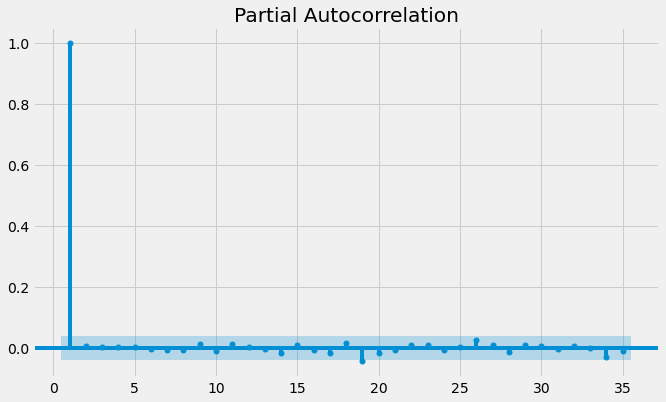

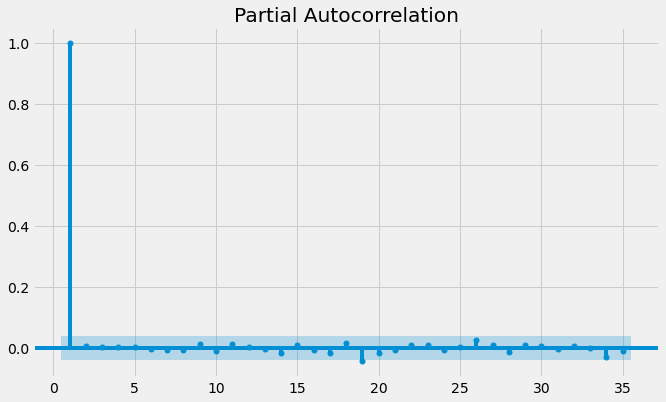

In [10]:
# Plot the partial autocorrelation 
plot_pacf(ticker_log_df, zero=False, lags=35)

Rolling forecast

In [53]:
def daily_forecast(train, num_days):
    autoarima_model = auto_arima(
        train, start_p=0, start_q=0,
        test='adf',       # use adftest to find optimal 'd'
        max_p=2, max_q=2, # maximum p and q
        m=1,              # frequency of series
        d=None,           # let model determine 'd'
        seasonal=False,   # No Seasonality
        start_P=0, 
        D=0, 
        trace=False,
        error_action='ignore',  
        suppress_warnings=True, 
        stepwise=True)
#     order = autoarima_model.get_params()['order']
#     model = ARIMA(train, order=order)
#     model_fit = model.fit(disp=0)
    return autoarima_model.predict(num_days)

In [54]:
def rolling_forecast(step=1):
    train_tmp = train_data
    predictions = []
    for i in range(0, len(test_data), step):
        print("Iteration ", i)
        predictions.extend(daily_forecast(train_tmp, step))
        train_tmp = train_tmp.append(test_data[i:(i+step)])
    return predictions

In [55]:
predictions = rolling_forecast(5)

Iteration  0
Iteration  5
Iteration  10
Iteration  15
Iteration  20
Iteration  25
Iteration  30
Iteration  35
Iteration  40
Iteration  45
Iteration  50
Iteration  55
Iteration  60
Iteration  65
Iteration  70
Iteration  75
Iteration  80
Iteration  85
Iteration  90
Iteration  95
Iteration  100
Iteration  105
Iteration  110
Iteration  115
Iteration  120
Iteration  125
Iteration  130
Iteration  135
Iteration  140
Iteration  145
Iteration  150
Iteration  155
Iteration  160
Iteration  165
Iteration  170
Iteration  175
Iteration  180
Iteration  185
Iteration  190
Iteration  195
Iteration  200
Iteration  205
Iteration  210
Iteration  215
Iteration  220
Iteration  225
Iteration  230
Iteration  235
Iteration  240
Iteration  245
Iteration  250
Iteration  255
Iteration  260
Iteration  265
Iteration  270
Iteration  275
Iteration  280
Iteration  285
Iteration  290
Iteration  295
Iteration  300
Iteration  305
Iteration  310
Iteration  315
Iteration  320
Iteration  325
Iteration  330
Iteration  335
It

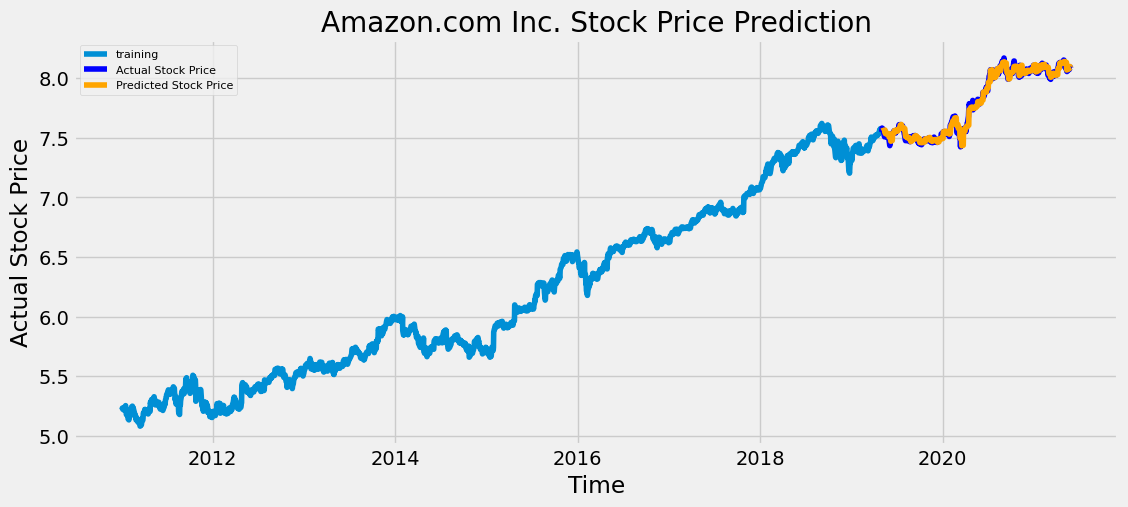

In [58]:
pred_series = pd.Series(predictions[:len(test_data)], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(pred_series, color = 'orange',label='Predicted Stock Price')
plt.title('Amazon.com Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [42]:
# report performance
mse = mean_squared_error(test_data, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, predictions))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.00019459273044677451
MAE: 0.011185689641447874
RMSE: 0.013949649832407067
MAPE: 0.0013819238011844538


### 2. Auto Arima

It automatically obtain the optimal parameters of the model.

In [43]:
autoarima_model = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(autoarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12978.124, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12977.796, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12977.859, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12971.799, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12975.826, Time=0.40 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.465 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2592
Model:               SARIMAX(0, 1, 0)   Log Likelihood                6491.062
Date:                Sat, 05 Jun 2021   AIC                         -12978.124
Time:                        00:41:17   BIC                         -12966.404
Sample:                             0   HQIC                        -12973.877
                               - 2592                             

In [26]:
autoarima_model.get_params()['order']

(1, 1, 1)

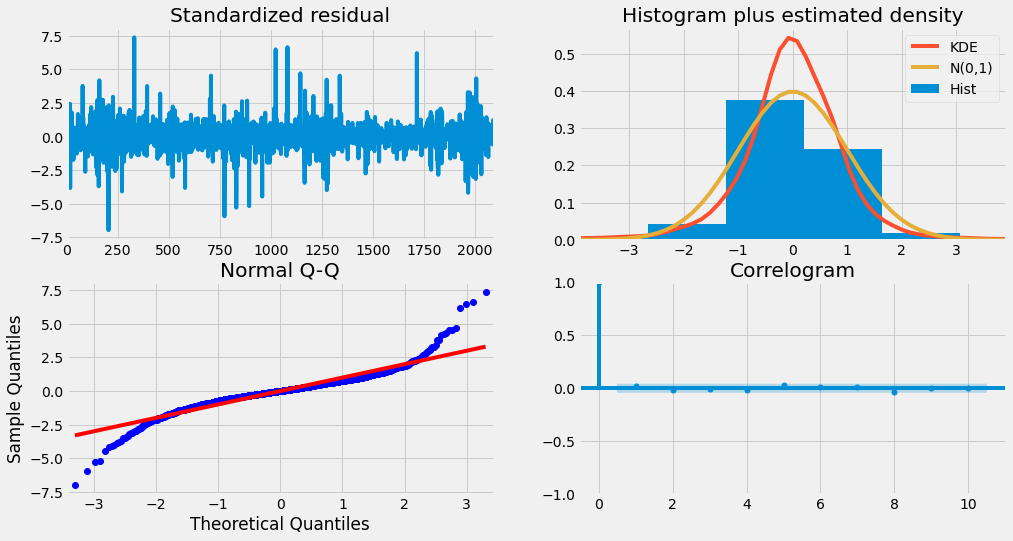

In [12]:
autoarima_model.plot_diagnostics(figsize=(15,8))
plt.show()

From the above plot, we can observe that:

In standardized residual plot, residual error fluctuates around the mean of zero and the variance become constant.

In Histogram density plot, we see the normal distribution with mean zero.

The Normal Q-Q figure suggest that there is some significant deviation.

The correlogram(ACF) plot shows that there is some autocorrelation.

### Build Arima model 

Using the Close Price, estimate an ARIMA model. Set P=1, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(1,1,1)) P= parameter of Auto-Regressive Lag 1, D= parameter of Differences 1 (this is usually =1), Q= parameter of Moving Average Lag of 1

In [25]:
model = ARIMA(train_data, order=(1,1,1))
arima_results = arima_model.fit(disp=0)
arima_results.summary()

/Users/soma/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/soma/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 2094
Model:                 ARIMA(1, 1, 1)   Log Likelihood                5250.034
Method:                       css-mle   S.D. of innovations              0.020
Date:                Fri, 04 Jun 2021   AIC                         -10492.069
Time:                        23:56:18   BIC                         -10469.481
Sample:                             1   HQIC                        -10483.794
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.000      3.293      0.001       0.000       0.002
ar.L1.D.Close     0.9017      0.091      9.955      0.000       0.724       1.079
ma.L1.D.Close    -0.9226      0.081    -11.391      0.000      -1.081      -0.764
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1090           +0.0000j            1.1090            0.0000
MA.1            1.0838           +0.0000j            1.0838            0.0000
-----------------------------------------------------------------------------
"""

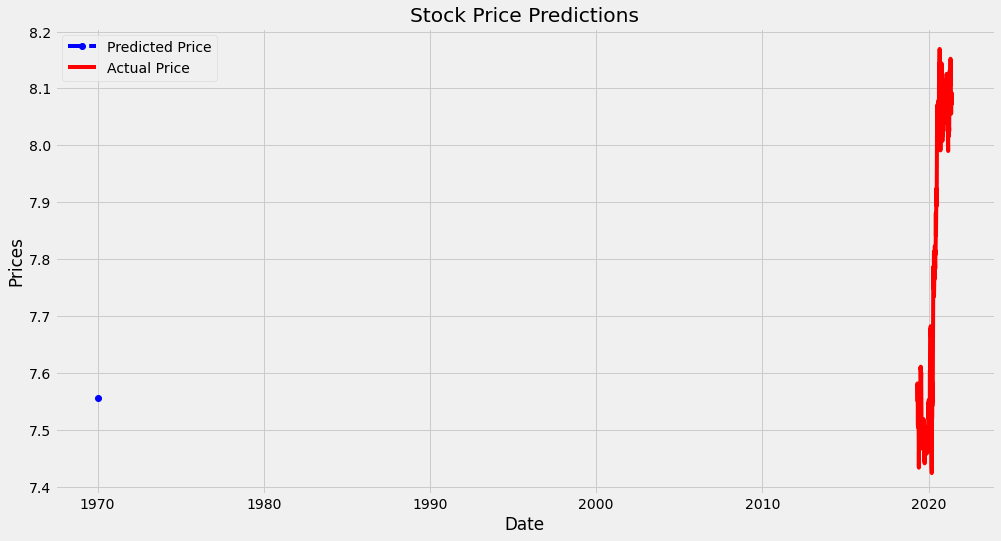

In [28]:
predictions, _, _ = arima_results.forecast()
plt.figure(figsize=(15, 8))
predicted_plot = plt.plot(predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
actual_plot = plt.plot(test_data, color='red', label='Actual Price')
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [29]:
predictions

array([7.55642775])

In [20]:
predictions

(array([7.55642775]), array([0.01972]), array([[7.51777726, 7.59507823]]))